## Capstone 1 Project: Prediction of Churn for Telecom Customers (Machine Learning)

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import sklearn as sk

# disable warnings
import warnings
warnings.filterwarnings('ignore')


csvfile = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'

df = pd.read_csv(csvfile)

df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df = df.dropna()
df = df.drop(columns='customerID')

# creating dummy variables to resolve categorical features
categ_feats = list(df.columns.values)
list_to_remove = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
categ_feats = list(set(categ_feats).difference(set(list_to_remove)))
df = pd.get_dummies(df, columns = categ_feats)   

plt.style.use('ggplot')

/Users/albertchiu/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

X = df.drop('Churn', axis=1).values
y = df['Churn'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

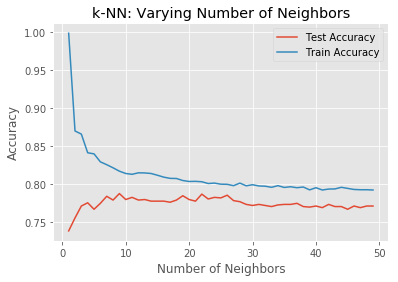

In [3]:
# KNN with normalization

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier

# normalizing data to reduce the influence of features with high numerical values
X_normalized = preprocessing.normalize(X, norm='l2')
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_normalized, y, test_size=0.2, random_state=21)

neighbors = np.arange(1, 50)
knn_train_accuracy = np.empty(len(neighbors))
knn_test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):   # saving train and test accuracy for different neighbor values
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_norm, y_train_norm)
    knn_train_accuracy[i] = knn.score(X_train_norm, y_train_norm)
    knn_test_accuracy[i] = knn.score(X_test_norm, y_test_norm)
    
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, knn_test_accuracy, label = 'Test Accuracy')
plt.plot(neighbors, knn_train_accuracy, label = 'Train Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [4]:
# Normalized k-NN classifier: identifying best k value with GridSearchCV

from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': np.arange(1, 30)}

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train_norm, y_train_norm)

print('k-NN best n_neighbors:', knn_cv.best_params_, '\n')

y_pred_knn_test = knn_cv.predict(X_test_norm)

print('k-NN test set confusion matrix:')
print(confusion_matrix(y_test_norm, y_pred_knn_test), '\n')
print('k-NN test set classification report:')
print(classification_report(y_test_norm, y_pred_knn_test))

k-NN best n_neighbors: {'n_neighbors': 14} 

k-NN test set confusion matrix:
[[903 104]
 [209 191]] 

k-NN test set classification report:
              precision    recall  f1-score   support

          No       0.81      0.90      0.85      1007
         Yes       0.65      0.48      0.55       400

   micro avg       0.78      0.78      0.78      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407



In [5]:
%%time

# Lasso Logistic Regression classifier (L1 regularization)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid_L1 = {'C': np.arange(.5, 5, .5)}   # possible values for C

logreg_L1 = LogisticRegression(penalty='l1')   
logreg_L1_cv = GridSearchCV(logreg_L1, param_grid_L1, cv=5)
logreg_L1_cv.fit(X_train, y_train)

print('Lasso Reg best C value', logreg_L1_cv.best_params_, '\n')

y_pred_L1_train = logreg_L1_cv.predict(X_train)
y_pred_L1_test = logreg_L1_cv.predict(X_test)

print('Lasso Reg train set confusion matrix:')
print(confusion_matrix(y_train, y_pred_L1_train), '\n')
print('Lasso Reg train set classification report:')
print(classification_report(y_train, y_pred_L1_train), '\n')

print('Lasso Reg test set confusion matrix:')
print(confusion_matrix(y_test, y_pred_L1_test), '\n')
print('Lasso Reg test set classification report:')
print(classification_report(y_test, y_pred_L1_test))

Lasso Reg best C value {'C': 0.5} 

Lasso Reg train set confusion matrix:
[[3740  416]
 [ 659  810]] 

Lasso Reg train set classification report:
              precision    recall  f1-score   support

          No       0.85      0.90      0.87      4156
         Yes       0.66      0.55      0.60      1469

   micro avg       0.81      0.81      0.81      5625
   macro avg       0.76      0.73      0.74      5625
weighted avg       0.80      0.81      0.80      5625
 

Lasso Reg test set confusion matrix:
[[909  98]
 [193 207]] 

Lasso Reg test set classification report:
              precision    recall  f1-score   support

          No       0.82      0.90      0.86      1007
         Yes       0.68      0.52      0.59       400

   micro avg       0.79      0.79      0.79      1407
   macro avg       0.75      0.71      0.72      1407
weighted avg       0.78      0.79      0.78      1407

CPU times: user 6.92 s, sys: 129 ms, total: 7.05 s
Wall time: 7.49 s


In [6]:
# Ridge Logistic Regression classifier (L2 regularization)

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

param_grid_L2 = {'C': np.arange(.5, 5, .5)}   # possible values for C

logreg_L2 = LogisticRegression(penalty='l2')   
logreg_L2_cv = GridSearchCV(logreg_L2, param_grid_L2, cv=5)
logreg_L2_cv.fit(X_train, y_train)

print('Ridge Reg best C value', logreg_L2_cv.best_params_, '\n')

y_pred_L2_train = logreg_L2_cv.predict(X_train)
y_pred_L2_test = logreg_L2_cv.predict(X_test)

print('Ridge Reg train set confusion matrix:')
print(confusion_matrix(y_train, y_pred_L2_train), '\n')
print('Ridge Reg train set classification report:')
print(classification_report(y_train, y_pred_L2_train), '\n')

print('Ridge Reg test set confusion matrix:')
print(confusion_matrix(y_test, y_pred_L2_test), '\n')
print('Ridge Reg test set classification report:')
print(classification_report(y_test, y_pred_L2_test))

Ridge Reg best C value {'C': 4.5} 

Ridge Reg train set confusion matrix:
[[3745  411]
 [ 662  807]] 

Ridge Reg train set classification report:
              precision    recall  f1-score   support

          No       0.85      0.90      0.87      4156
         Yes       0.66      0.55      0.60      1469

   micro avg       0.81      0.81      0.81      5625
   macro avg       0.76      0.73      0.74      5625
weighted avg       0.80      0.81      0.80      5625
 

Ridge Reg test set confusion matrix:
[[906 101]
 [196 204]] 

Ridge Reg test set classification report:
              precision    recall  f1-score   support

          No       0.82      0.90      0.86      1007
         Yes       0.67      0.51      0.58       400

   micro avg       0.79      0.79      0.79      1407
   macro avg       0.75      0.70      0.72      1407
weighted avg       0.78      0.79      0.78      1407



In [7]:
# writing functions to plot precision, recall and F1 scores for Lasso and Ridge Models for various values of C

def class_report_data(y_train, y_train_pred, y_test, y_test_pred):
    
    clf_rep_train = precision_recall_fscore_support(y_train, y_train_pred)
    clf_rep_test = precision_recall_fscore_support(y_test, y_test_pred)

    out_dict_train = {"precision" : clf_rep_train[0].round(2),
                      "recall" : clf_rep_train[1].round(2),
                      "f1-score" : clf_rep_train[2].round(2),
                      "support" : clf_rep_train[3]}

    out_dict_test = {"precision" : clf_rep_test[0].round(2),
                      "recall" : clf_rep_test[1].round(2),
                      "f1-score" : clf_rep_test[2].round(2),
                      "support" : clf_rep_test[3]}
    
    out_df_train = pd.DataFrame(out_dict_train)
    out_df_test = pd.DataFrame(out_dict_test)
    out_df_train.index  = ['No', 'Yes']
    out_df_test.index = ['No', 'Yes']

    tr_pre_nc = out_df_train.loc['No', 'precision']
    tr_rec_nc = out_df_train.loc['No', 'recall']
    tr_f1s_nc = out_df_train.loc['No', 'f1-score']
    tr_pre_c = out_df_train.loc['Yes', 'precision']
    tr_rec_c = out_df_train.loc['Yes', 'recall']
    tr_f1s_c = out_df_train.loc['Yes', 'f1-score']
    
    te_pre_nc = out_df_test.loc['No', 'precision']
    te_rec_nc = out_df_test.loc['No', 'recall']
    te_f1s_nc = out_df_test.loc['No', 'f1-score']
    te_pre_c = out_df_test.loc['Yes', 'precision']
    te_rec_c = out_df_test.loc['Yes', 'recall']
    te_f1s_c = out_df_test.loc['Yes', 'f1-score']
    
    train_class_report_list = [tr_pre_nc, tr_rec_nc, tr_f1s_nc, tr_pre_c, tr_rec_c, tr_f1s_c]
    test_class_report_list = [te_pre_nc, te_rec_nc, te_f1s_nc, te_pre_c, te_rec_c, te_f1s_c]
    
    return train_class_report_list, test_class_report_list

def graph_logreg(penalty, C):
    
    C_range = np.arange(1, C)

    tr_pre_nc, tr_rec_nc, tr_f1s_nc = (np.empty(len(C_range)) for _ in range(3))
    tr_pre_c, tr_rec_c, tr_f1s_c = (np.empty(len(C_range)) for _ in range(3))
    te_pre_nc, te_rec_nc, te_f1s_nc = (np.empty(len(C_range)) for _ in range(3))
    te_pre_c, te_rec_c, te_f1s_c = (np.empty(len(C_range)) for _ in range(3))
    
    for i, C in enumerate(C_range):
        logreg = LogisticRegression(penalty = penalty, C = C)
        logreg.fit(X_train, y_train)
        
        y_train_pred = logreg.predict(X_train)
        y_test_pred = logreg.predict(X_test)
        
        train_list, test_list = class_report_data(y_train, y_train_pred, y_test, y_test_pred)
        
        tr_pre_nc[i] = train_list[0]
        tr_rec_nc[i] = train_list[1]
        tr_f1s_nc[i] = train_list[2]
        tr_pre_c[i] = train_list[3]
        tr_rec_c[i] = train_list[4]
        tr_f1s_c[i] = train_list[5]
        
        te_pre_nc[i] = test_list[0]
        te_rec_nc[i] = test_list[1]
        te_f1s_nc[i] = test_list[2]
        te_pre_c[i] = test_list[3]
        te_rec_c[i] = test_list[4]
        te_f1s_c[i] = test_list[5]
    
    _ = plt.title('{} Logistic Regression Precision'.format(penalty))
    _ = plt.plot(C_range, tr_pre_nc, label = 'Train No Churn')
    _ = plt.plot(C_range, tr_pre_c, label = 'Train Churn')
    _ = plt.plot(C_range, te_pre_nc, label = 'Test No Churn')
    _ = plt.plot(C_range, te_pre_c, label = 'Test Churn')
    _ = plt.legend()
    _ = plt.xlabel('Value of C')
    _ = plt.ylabel('Precision')
    plt.show()
        
    _ = plt.title('{} Logistic Regression Recall'.format(penalty))
    _ = plt.plot(C_range, tr_rec_nc, label = 'Train No Churn')
    _ = plt.plot(C_range, tr_rec_c, label = 'Train Churn')
    _ = plt.plot(C_range, te_rec_nc, label = 'Test No Churn')
    _ = plt.plot(C_range, te_rec_c, label = 'Test Churn')
    _ = plt.legend()
    _ = plt.xlabel('Value of C')
    _ = plt.ylabel('Recall')
    plt.show()
    
    _ = plt.title('{} Logistic Regression F1 Score'.format(penalty))
    _ = plt.plot(C_range, tr_f1s_nc, label = 'Train No Churn')
    _ = plt.plot(C_range, tr_f1s_c, label = 'Train Churn')
    _ = plt.plot(C_range, te_f1s_nc, label = 'Test No Churn')
    _ = plt.plot(C_range, te_f1s_c, label = 'Test Churn')
    _ = plt.legend()
    _ = plt.xlabel('Value of C')
    _ = plt.ylabel('F1 Score')
    plt.show()


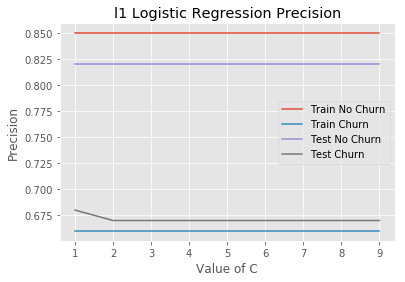

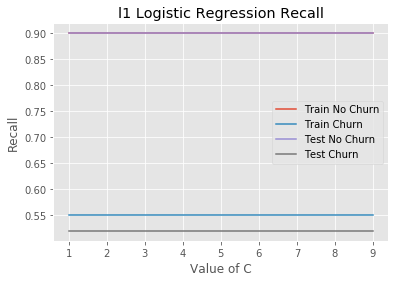

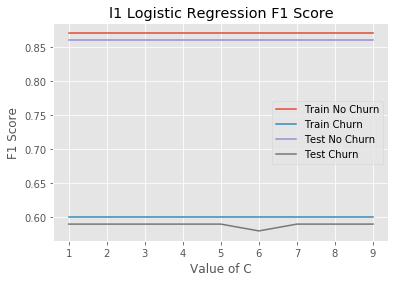

In [8]:
# Lasso Regression Model - graphing performance

graph_logreg('l1', 10)

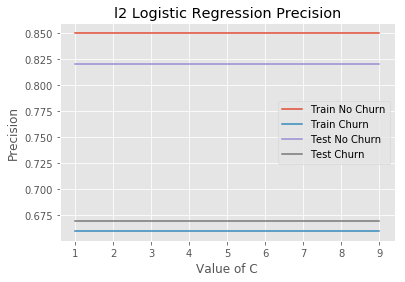

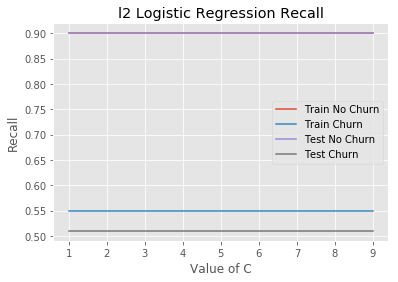

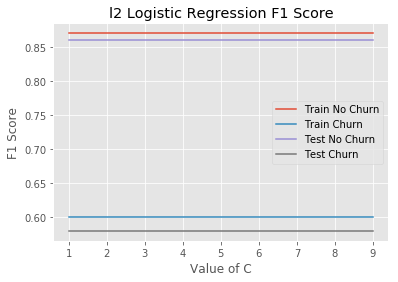

In [9]:
# Ridge Regression Model - graphing performance

graph_logreg('l2', 10)

In [10]:
%%time

# Random Forest classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


param_grid_rf = {'n_estimators': np.arange(10, 2000, 10), 
                 'max_features': ['auto', 'sqrt'],
                 'max_depth': np.arange(10, 200, 10),
                 'criterion': ['gini', 'entropy'],
                 'bootstrap': [True, False]}

rf = RandomForestClassifier()
rf_random_grid = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf, cv=5)
rf_random_grid.fit(X_train, y_train)

y_pred_rf_test = rf_random_grid.predict(X_test)

print('Tuned Random Forest Params:', rf_random_grid.best_params_, '\n')
print('Tuned Random Forest score is {}.'.format(rf_random_grid.best_score_.round(3)), '\n')

print('Tuned Random Forest test set confusion matrix:')
print(confusion_matrix(y_test, y_pred_rf_test), '\n')
print('Tuned Random Forest test set classification report:')
print(classification_report(y_test, y_pred_rf_test), '\n')

Tuned Random Forest Params: {'n_estimators': 740, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': True} 

Tuned Random Forest score is 0.801. 

Tuned Random Forest test set confusion matrix:
[[917  90]
 [200 200]] 

Tuned Random Forest test set classification report:
              precision    recall  f1-score   support

          No       0.82      0.91      0.86      1007
         Yes       0.69      0.50      0.58       400

   micro avg       0.79      0.79      0.79      1407
   macro avg       0.76      0.71      0.72      1407
weighted avg       0.78      0.79      0.78      1407
 

CPU times: user 7min 21s, sys: 9.93 s, total: 7min 31s
Wall time: 7min 53s


In [11]:
# using oversampling with Random Forest to address dataset imbalance

from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import RandomOverSampler, SMOTE

# our classifier to use
classifier_1 = RandomForestClassifier
classifier_2 = LogisticRegression

# building model with random oversampling and Random Forest
ros_rf_pipeline = make_pipeline_imb(RandomOverSampler(random_state=4), classifier_1(random_state=42))
ros_rf_model = ros_rf_pipeline.fit(X_train, y_train)

y_pred_ros_rf_test = ros_rf_model.predict(X_test)
X_ros_rf_resample, y_ros_rf_resample = RandomOverSampler().fit_sample(X_train, y_train)

# building model with random oversampling and Logistic Regression
ros_lr_pipeline = make_pipeline_imb(RandomOverSampler(random_state=4), classifier_2(random_state=42))
ros_lr_model = ros_lr_pipeline.fit(X_train, y_train)

y_pred_ros_lr_test = ros_lr_model.predict(X_test)
X_ros_lr_resample, y_ros_lr_resample = RandomOverSampler().fit_sample(X_train, y_train)

# building model with SMOTE and Random Forest
smote_rf_pipeline = make_pipeline_imb(SMOTE(random_state=42), classifier_1(random_state=42))
smote_rf_model = smote_rf_pipeline.fit(X_train, y_train)

y_pred_smote_rf_test = smote_rf_model.predict(X_test)
X_smote_rf_resample, y_smote_rf_resample = SMOTE().fit_sample(X_train, y_train)

# building model with SMOTE and Logistic Regression
smote_lr_pipeline = make_pipeline_imb(SMOTE(random_state=42), classifier_2(random_state=42))
smote_lr_model = smote_lr_pipeline.fit(X_train, y_train)

y_pred_smote_lr_test = smote_lr_model.predict(X_test)
X_smote_lr_resample, y_smote_lr_resample = SMOTE().fit_sample(X_train, y_train)

# print confusion matrix and classification reports
print('Random Over-Sampler w/ Random Forest confusion matrix:')
print(confusion_matrix(y_test, y_pred_ros_rf_test), '\n')
print('Random Over-Sampler w/ Random Forest classification report:')
print(classification_report(y_test, y_pred_ros_rf_test), '\n')

print('SMOTE w/ Random Forest confusion matrix:')
print(confusion_matrix(y_test, y_pred_smote_rf_test), '\n')
print('SMOTE w/ Random Foreset classification report:')
print(classification_report(y_test, y_pred_smote_rf_test), '\n')

print('Random Over-Sampler w/ Logistic Regression confusion matrix:')
print(confusion_matrix(y_test, y_pred_ros_lr_test), '\n')
print('Random Over-Sampler w/ Logistic Regression classification report:')
print(classification_report(y_test, y_pred_ros_lr_test), '\n')

print('SMOTE w/ Logistic Regression confusion matrix:')
print(confusion_matrix(y_test, y_pred_smote_lr_test), '\n')
print('SMOTE w/ Logistic Regression classification report:')
print(classification_report(y_test, y_pred_smote_lr_test), '\n')


Random Over-Sampler w/ Random Forest confusion matrix:
[[875 132]
 [186 214]] 

Random Over-Sampler w/ Random Forest classification report:
              precision    recall  f1-score   support

          No       0.82      0.87      0.85      1007
         Yes       0.62      0.54      0.57       400

   micro avg       0.77      0.77      0.77      1407
   macro avg       0.72      0.70      0.71      1407
weighted avg       0.77      0.77      0.77      1407
 

SMOTE w/ Random Forest confusion matrix:
[[909  98]
 [223 177]] 

SMOTE w/ Random Foreset classification report:
              precision    recall  f1-score   support

          No       0.80      0.90      0.85      1007
         Yes       0.64      0.44      0.52       400

   micro avg       0.77      0.77      0.77      1407
   macro avg       0.72      0.67      0.69      1407
weighted avg       0.76      0.77      0.76      1407
 

Random Over-Sampler w/ Logistic Regression confusion matrix:
[[746 261]
 [ 72 328]] 

Ran

In [12]:
# using undersampling to address dataset imbalance

from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

# our classifier to use
classifier_1 = RandomForestClassifier
classifier_2 = LogisticRegression

# building model with random undersampling and Random Forest
rus_rf_pipeline = make_pipeline_imb(RandomUnderSampler(random_state=4), classifier_1(random_state=42))
rus_rf_model = rus_rf_pipeline.fit(X_train, y_train)

y_pred_rus_rf_test = rus_rf_model.predict(X_test)
X_rus_rf_resample, y_rus_rf_resample = RandomUnderSampler().fit_sample(X_train, y_train)

# building model with random undersampling and Logistic Regression
rus_lr_pipeline = make_pipeline_imb(RandomUnderSampler(random_state=4), classifier_2(random_state=42))
rus_lr_model = rus_lr_pipeline.fit(X_train, y_train)

y_pred_rus_lr_test = rus_lr_model.predict(X_test)
X_rus_lr_resample, y_rus_lr_resample = RandomUnderSampler().fit_sample(X_train, y_train)

# building model with Tomek Links and Random Forest
tl_rf_pipeline = make_pipeline_imb(TomekLinks(random_state=4), classifier_1(random_state=42))
tl_rf_model = tl_rf_pipeline.fit(X_train, y_train)

y_pred_tl_rf_test = tl_rf_model.predict(X_test)
X_tl_rf_resample, y_tl_rf_resample = TomekLinks().fit_sample(X_train, y_train)

# building model with Tomek Links and Logistic Regression
tl_lr_pipeline = make_pipeline_imb(TomekLinks(random_state=4), classifier_2(random_state=42))
tl_lr_model = tl_lr_pipeline.fit(X_train, y_train)

y_pred_tl_lr_test = tl_lr_model.predict(X_test)
X_tl_lr_resample, y_tl_lr_resample = TomekLinks().fit_sample(X_train, y_train)

# print confusion matrices and classification reports
print('Random Under-Sampler w/ Random Forest confusion matrix:')
print(confusion_matrix(y_test, y_pred_rus_rf_test), '\n')
print('Random Under-Sampler w/ Random Forest classification report:')
print(classification_report(y_test, y_pred_rus_rf_test), '\n')

print('Tomek Links w/ Random Forest confusion matrix:')
print(confusion_matrix(y_test, y_pred_tl_rf_test), '\n')
print('Tomek Links w/ Random Forest classification report:')
print(classification_report(y_test, y_pred_tl_rf_test), '\n')

print('Random Under-Sampler w/ Logistic Regression confusion matrix:')
print(confusion_matrix(y_test, y_pred_rus_lr_test), '\n')
print('Random Under-Sampler w/ Logistic Regression classification report:')
print(classification_report(y_test, y_pred_rus_lr_test), '\n')

print('Tomek Links w/ Logistic Regression confusion matrix:')
print(confusion_matrix(y_test, y_pred_tl_lr_test), '\n')
print('Tomek Links w/ Logistic Regression classification report:')
print(classification_report(y_test, y_pred_tl_lr_test), '\n')


Random Under-Sampler w/ Random Forest confusion matrix:
[[751 256]
 [115 285]] 

Random Under-Sampler w/ Random Forest classification report:
              precision    recall  f1-score   support

          No       0.87      0.75      0.80      1007
         Yes       0.53      0.71      0.61       400

   micro avg       0.74      0.74      0.74      1407
   macro avg       0.70      0.73      0.70      1407
weighted avg       0.77      0.74      0.75      1407
 

Tomek Links w/ Random Forest confusion matrix:
[[894 113]
 [184 216]] 

Tomek Links w/ Random Forest classification report:
              precision    recall  f1-score   support

          No       0.83      0.89      0.86      1007
         Yes       0.66      0.54      0.59       400

   micro avg       0.79      0.79      0.79      1407
   macro avg       0.74      0.71      0.73      1407
weighted avg       0.78      0.79      0.78      1407
 

Random Under-Sampler w/ Logistic Regression confusion matrix:
[[729 278]
 [ 

In [13]:
# creating table of the classification reports for all algorithms

from sklearn.metrics import precision_recall_fscore_support as score

algorithm_dict = {'k-NN':y_pred_knn_test, 
              'Lasso Reg':y_pred_L1_test, 
              'Ridge Reg':y_pred_L2_test,
              'Random Forest':y_pred_rf_test,
              'Random Forest w/ Random Over-Sampler':y_pred_ros_rf_test,
              'Random Forest w/ SMOTE':y_pred_smote_rf_test,
              'Log Reg w/ Random Over-Sampler':y_pred_ros_lr_test,
              'Log Reg w/ SMOTE':y_pred_smote_lr_test,
              'Random Forest w/ Random Under-Sampler':y_pred_rus_rf_test,
              'Random Forest w/ Tomek Links':y_pred_tl_rf_test,
              'Log Reg w/ Random Under-Sampler':y_pred_rus_lr_test,
              'Log Reg w/ Tomek Links':y_pred_tl_lr_test}

nochurn_class_report_df = pd.DataFrame(index=algorithm_dict.keys(), columns=['Precision', 'Recall', 'F-score', 'Support'])
churn_class_report_df = pd.DataFrame(index=algorithm_dict.keys(), columns=['Precision', 'Recall', 'F-score', 'Support'])

for key, value in algorithm_dict.items():
    
    precision, recall, fscore, support = score(y_test, value)
    
    nochurn_class_report_df.loc[key, 'Precision'] = precision[0].round(4)
    nochurn_class_report_df.loc[key, 'Recall'] = recall[0].round(4)
    nochurn_class_report_df.loc[key, 'F-score'] = fscore[0].round(4)
    nochurn_class_report_df.loc[key, 'Support'] = support[0]
    
    churn_class_report_df.loc[key, 'Precision'] = precision[1].round(4)
    churn_class_report_df.loc[key, 'Recall'] = recall[1].round(4)
    churn_class_report_df.loc[key, 'F-score'] = fscore[1].round(4)
    churn_class_report_df.loc[key, 'Support'] = support[1]

print('Classification report results for non-churn customers:')
print(nochurn_class_report_df, '\n')
    
print('Classification report results for churn customers:')
print(churn_class_report_df, '\n')


Classification report results for non-churn customers:
                                      Precision  Recall F-score Support
k-NN                                     0.8121  0.8967  0.8523    1007
Lasso Reg                                0.8249  0.9027   0.862    1007
Ridge Reg                                0.8221  0.8997  0.8592    1007
Random Forest                            0.8209  0.9106  0.8635    1007
Random Forest w/ Random Over-Sampler     0.8247  0.8689  0.8462    1007
Random Forest w/ SMOTE                    0.803  0.9027  0.8499    1007
Log Reg w/ Random Over-Sampler            0.912  0.7408  0.8175    1007
Log Reg w/ SMOTE                         0.9096  0.7398   0.816    1007
Random Forest w/ Random Under-Sampler    0.8672  0.7458  0.8019    1007
Random Forest w/ Tomek Links             0.8293  0.8878  0.8576    1007
Log Reg w/ Random Under-Sampler          0.9101  0.7239  0.8064    1007
Log Reg w/ Tomek Links                   0.8427   0.862  0.8522    1007 

Classif

The main metric that we will be using to measure performance is churn recall since we are interested in identifying as many of actual churn customers as possible.  After compiling the classification report results for all the estimators, it appears that Logistic Regression paired with Random Oversampling, SMOTE and Random Undersampling are the best performing classifiers.  